# Deconvolution

Inspired by cell type deconvolution, I fit nonnegative least squares regression to estimate a vector of weights which represent the similarity between the test sample and other samples.

## Data Loading
Load the training and test data.

In [1]:
import pandas as pd
import numpy as np

geneexp_train = pd.read_csv("data/train_data.csv", index_col=0)
geneexp_test = pd.read_csv("data/test_data.csv", index_col=0)
genenames = np.array(geneexp_train.index.tolist())

In [2]:
geneexpmat_train = geneexp_train.to_numpy()
prevalence = np.mean(geneexpmat_train > 0, axis=1)
subset_gene_id = np.where(prevalence == 1)[0]
subset_genenames = genenames[subset_gene_id]

In [3]:
geneexp_train = geneexp_train.loc[subset_genenames, :]
geneexp_test = geneexp_test.loc[subset_genenames, :]

In [4]:
timepoints_train = geneexp_train.columns.tolist()

In [5]:
import re
# extract the month numbers
def extract_number(mystring):
    numbers = re.findall("^\d+", mystring)
    return int(numbers[0])
# get the ages
ages_train = np.array([extract_number(timestring) for timestring in timepoints_train])

In [6]:
geneexp_train_t = pd.DataFrame(geneexp_train.T, columns=subset_genenames)
geneexp_test_t = pd.DataFrame(geneexp_test.T, columns=subset_genenames)
geneexp_train_t["Age"] = ages_train

## Variance Calculation
The deconvolution is essentially a weighted linear regression for all the genes. The weight calculate depends on the variance of each gene. If the between age variance is much larger than the within age variance, then more weight should be put on that gene.

In [7]:
from data.utils import meanexp, group_counts, sum_squares

In [18]:
unique_ages=np.unique(ages_train)
geneexp_indv = geneexp_train.T.to_numpy()
geneexp_agemean = meanexp(geneexp_train_t, group="Age")
geneexp_mean = meanexp(geneexp_train_t)
geneexp_mean = geneexp_mean[:-1]
age_counts = group_counts(geneexp_train_t, group="Age")

In [19]:
SST = sum_squares(matrix=geneexp_indv, vec=geneexp_mean, sd=False) # total sum of squares
SSG = sum_squares(matrix=geneexp_agemean, vec=geneexp_mean, weights=age_counts, sd=False)
sd_genes = sum_squares(matrix=geneexp_indv, vec=geneexp_mean, sd=True) # total sum of squares

In [28]:
geneexp_mean

array([ 0.44563287, 10.64123179, 27.87789609, ...,  1.04187944,
        2.95460537,  1.8801302 ])

In [30]:
geneexp_agemean

array([[ 0.55971274, 16.46069182, 45.78437537, ...,  1.01056451,
         0.1874139 ,  1.84684971],
       [ 0.16386272, 13.36012625, 37.57994361, ...,  1.32857263,
         3.11459199,  1.61114661],
       [ 0.40458914,  8.71206225, 18.90243487, ...,  1.16090706,
         3.09641586,  1.42513041],
       ...,
       [ 0.26951644, 10.20867393, 31.49409513, ...,  0.66809848,
         3.21842864,  1.51721811],
       [ 0.47850522, 10.12642083, 23.85764009, ...,  1.09354731,
         1.57361484,  2.36006735],
       [ 0.36072196,  9.59539272, 22.07518307, ...,  0.78896206,
         3.01863969,  1.22387124]])

In [29]:
Rsquare[0:10]

array([0.425698  , 0.77882932, 0.77419572, 0.76670481, 0.61057533,
       0.48763413, 0.4535008 , 0.33953205, 0.50829529, 0.88379319])

In [23]:
Rsquare = SSG/SST # higher Rsquared, higher weights when doing deconvolution
np.max(Rsquare)

0.9324871223965611

In [31]:
sorted_Rsquare = np.sort(Rsquare)
sorted_Rsquare = sorted_Rsquare[::-1]

In [35]:
sorted_Rsquare[8000]

0.546720142137659

## Deconvolution

In [100]:
from cvxopt import matrix, solvers
# Suppress GLPK output
solvers.options['glpk'] = {'msg_lev': 'GLP_MSG_OFF'}

In [109]:
weight_mat_1 = np.zeros((len(loggeneexp_df), len(unique_ages)))

Fit nonnegative least squares where the weights sum up to one.

In [110]:
for i in range(len(loggeneexp_df)):
    # target
    y = loggeneexp_df.iloc[i, :-1].to_numpy()
    y_age = loggeneexp_df.iloc[i, -1]

    # average expressions at different ages
    loggeneexp_df_loo = loggeneexp_df.drop(i)
    loggeneexp_df_loo = loggeneexp_df_loo.groupby("Age").mean()
    X_ages = np.array(loggeneexp_df_loo.index)
    X = loggeneexp_df_loo.to_numpy().T

    Q = matrix(np.matmul(X.transpose(), X)) # quadratic term
    P = -matrix(np.matmul(X.transpose(), y)) # linear term

    G = matrix(np.identity(X.shape[1])) * -1 # inequality, nonnegativity
    h = matrix(np.zeros(X.shape[1]))

    A = matrix(np.ones(X.shape[1]), (1, X.shape[1])) # sum to one constraint
    b = matrix(np.array([1.0]))

    solution = solvers.qp(Q,P,G,h,A,b)
    weights = np.array(solution['x'])

    weight_mat_1[i, :] = weights.flatten()

     pcost       dcost       gap    pres   dres
 0: -7.3552e+04 -7.3552e+04  4e+01  5e+00  2e-05
 1: -7.3552e+04 -7.3550e+04  1e+01  1e+00  4e-06
 2: -7.3538e+04 -7.3511e+04  3e+01  1e+00  4e-06
 3: -7.3530e+04 -7.3478e+04  4e+01  1e+00  3e-06
 4: -7.3499e+04 -7.3409e+04  6e+01  7e-01  2e-06
 5: -7.3488e+04 -7.3351e+04  7e+01  6e-01  2e-06
 6: -7.3453e+04 -7.3232e+04  1e+02  5e-01  1e-06
 7: -7.3202e+04 -7.3000e+04  2e+02  2e-01  7e-07
 8: -7.3142e+04 -7.2977e+04  1e+02  2e-01  5e-07
 9: -7.3105e+04 -7.2956e+04  1e+02  1e-01  4e-07
10: -7.3047e+04 -7.2883e+04  8e+01  7e-02  2e-07
11: -7.2834e+04 -7.2796e+04  3e+01  9e-03  3e-08
12: -7.2795e+04 -7.2795e+04  3e-01  1e-04  3e-10
13: -7.2795e+04 -7.2795e+04  3e-03  1e-06  3e-12
14: -7.2795e+04 -7.2795e+04  3e-05  1e-08  3e-14
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.4329e+04 -7.4330e+04  3e+01  5e+00  1e-05
 1: -7.4329e+04 -7.4329e+04  5e+00  9e-01  2e-06
 2: -7.4322e+04 -7.4319e+04  2e+01  7e-01  2e-0

In [127]:
weight_mat_1[weight_mat_1 < 1e-8] = 0
weight_mat_1 = np.round(weight_mat_1, decimals=4)
choice_1 = np.argmax(weight_mat_1, axis=1)
predicted_age_1 = unique_ages[choice_1]

In [130]:
import matplotlib.pyplot as plt
color_gray="#808080"
color_red="#db382c"
color_green="#2f7028"
color_brown="#665223"
color_blue="#344885"
color_magenta="#b538b3"
all_colors = [color_gray, color_red, color_green, color_brown, color_blue, color_magenta]

Let me try if the performance can be better if I use a smaller set of genes.

In [114]:
selected_genes = pd.read_csv("../enet/topgenes.tsv", sep='\t', index_col=0)
top_genes = selected_genes.index.tolist()

In [117]:
loggeneexp_df_subset = loggeneexp_df.loc[:, top_genes + ['Age']]

In [189]:
weight_mat_2 = np.zeros((len(loggeneexp_df_subset), len(unique_ages)))
for i in range(len(loggeneexp_df_subset)):
    # target
    y = loggeneexp_df_subset.iloc[i, :-1].to_numpy()
    y_age = loggeneexp_df_subset.iloc[i, -1]

    # average expressions at different ages
    loggeneexp_df_loo = loggeneexp_df_subset.drop(i)
    loggeneexp_df_loo = loggeneexp_df_loo.groupby("Age").mean()
    X_ages = np.array(loggeneexp_df_loo.index)
    X = loggeneexp_df_loo.to_numpy().T

    Q = matrix(np.matmul(X.transpose(), X)) # quadratic term
    P = -matrix(np.matmul(X.transpose(), y)) # linear term

    G = matrix(np.identity(X.shape[1])) * -1 # inequality, nonnegativity
    h = matrix(np.zeros(X.shape[1]))

    A = matrix(np.ones(X.shape[1]), (1, X.shape[1])) # sum to one constraint
    b = matrix(np.array([1.0]))

    solution = solvers.qp(Q,P,G,h,A,b)
    weights = np.array(solution['x'])

    weight_mat_2[i, :] = weights.flatten()

     pcost       dcost       gap    pres   dres
 0: -7.2952e+03 -7.2960e+03  4e+01  5e+00  1e-04
 1: -7.2951e+03 -7.2949e+03  4e+00  6e-01  2e-05
 2: -7.2940e+03 -7.2933e+03  2e+00  2e-01  7e-06
 3: -7.2930e+03 -7.2927e+03  5e-01  4e-02  1e-06
 4: -7.2926e+03 -7.2926e+03  2e-02  8e-04  3e-08
 5: -7.2926e+03 -7.2926e+03  5e-04  8e-06  3e-10
 6: -7.2926e+03 -7.2926e+03  5e-06  8e-08  3e-12
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.1742e+03 -7.1752e+03  3e+01  4e+00  1e-04
 1: -7.1741e+03 -7.1746e+03  2e+00  3e-01  9e-06
 2: -7.1739e+03 -7.1739e+03  5e-01  7e-02  2e-06
 3: -7.1736e+03 -7.1736e+03  1e-01  1e-02  3e-07
 4: -7.1735e+03 -7.1735e+03  5e-03  2e-04  5e-09
 5: -7.1735e+03 -7.1735e+03  8e-05  2e-06  5e-11
 6: -7.1735e+03 -7.1735e+03  8e-07  2e-08  5e-13
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -7.1438e+03 -7.1446e+03  4e+01  5e+00  1e-04
 1: -7.1437e+03 -7.1438e+03  4e+00  6e-01  2e-05
 2: -7.1431e+03 -7.1430e

In [191]:
y.shape

(1000,)

In [194]:
G

<15x15 matrix, tc='d'>

In [123]:
weight_mat_2[weight_mat_2 < 1e-8] = 0
weight_mat_2 = np.round(weight_mat_2, decimals=4)
choice_2 = np.argmax(weight_mat_2, axis=1)
predicted_age_2 = unique_ages[choice_2]

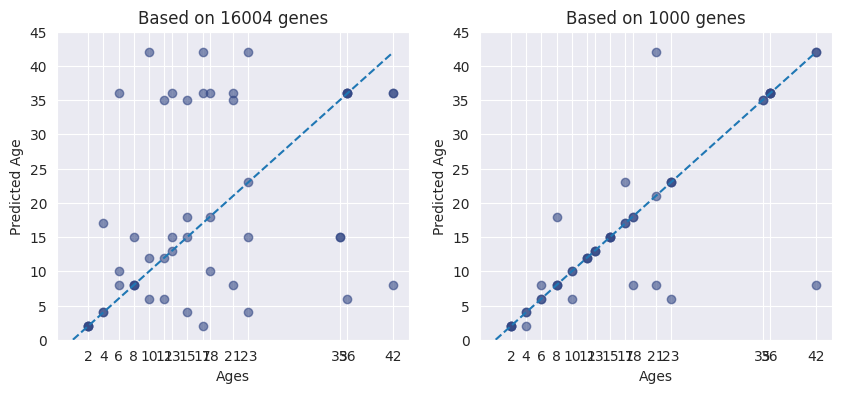

In [134]:
fig1, ax1 = plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

ax1[0].scatter(ages, predicted_age_1, color=color_blue, alpha=0.6)
ax1[0].set_xlabel('Ages')
ax1[0].set_xticks(unique_ages)
ax1[0].set_ylabel("Predicted Age")
ax1[0].set_title("Based on 16004 genes")
ax1[0].set_ylim(0, 45)
ax1[0].plot([0, 42], [0, 42], linestyle='--')

ax1[1].scatter(ages, predicted_age_2, color=color_blue, alpha=0.6)
ax1[1].set_xlabel('Ages')
ax1[1].set_xticks(unique_ages)
ax1[1].set_ylabel("Predicted Age")
ax1[1].set_title("Based on 1000 genes")
ax1[1].set_ylim(0, 45)
ax1[1].plot([0, 42], [0, 42], linestyle='--')

fig1.savefig("top_prediction.png", bbox_inches='tight')

In [149]:
unique_ages_str = unique_ages.astype('str')

In [162]:
for i in range(len(ages)):

    fig2, ax2=plt.subplots(figsize=(10, 4), nrows=1, ncols=2)

    true_age = str(ages[i])
    color_map = {true_age: "blue"}
    predicted_prob_1 = weight_mat_1[i, :]
    predicted_prob_2 = weight_mat_2[i, :]

    colors = [color_map.get(age, "gray") for age in unique_ages_str]

    ax2[0].set_ylim(0, 1)
    ax2[1].set_ylim(0, 1)
    ax2[0].bar(unique_ages_str, predicted_prob_1, color=colors)
    ax2[1].bar(unique_ages_str, predicted_prob_2, color=colors)

    ax2[0].set_xlabel("Age")
    ax2[1].set_xlabel("Age")
    ax2[0].set_ylabel("Weight")

    ax2[0].set_title("16004 genes")
    ax2[1].set_title("1000 genes")

    fig2.suptitle(f'True Age: {true_age}', fontsize=14)
    fig2.savefig(f"weights_{i}.png", bbox_inches='tight')
    plt.close(fig2)


In [195]:
Q = matrix(np.matmul(exampleintmat.transpose(), exampleintmat), (5,5), 'd') # quadratic term
P = -matrix(np.matmul(exampleintmat.transpose(), weighted_sum), (5,1), 'd') # linear term

G = matrix(np.identity(exampleintmat.shape[1])) * -1 # inequality, nonnegativity
h = matrix(np.zeros(exampleintmat.shape[1]))

A = matrix(np.ones(exampleintmat.shape[1]), (1, exampleintmat.shape[1])) # sum to one constraint
b = matrix(np.array([1.0]))

example_solution = solvers.qp(Q,P,G,h,A,b)

     pcost       dcost       gap    pres   dres
 0: -7.9636e+01 -8.0836e+01  1e+00  0e+00  9e-03
 1: -7.9639e+01 -7.9655e+01  2e-02  1e-16  1e-04
 2: -7.9639e+01 -7.9639e+01  2e-04  2e-17  1e-06
 3: -7.9639e+01 -7.9639e+01  2e-06  2e-16  1e-08
Optimal solution found.


In [196]:
np.array(example_solution['x'])

array([[0.10440501],
       [0.10308412],
       [0.10010387],
       [0.61598422],
       [0.07642278]])